# 誤差逆伝播法の実装

## ニューラルネットワークの学習の全体図

以下、斎藤（2016）より引用。

### 前提
* ニューラルネットワークは、適応可能な重みとバイアスがあり、この重みとバイアスを訓練データに適応するように調整することを「学習」と呼ぶ。
* ニューラルネットワークの学習は、次の4つの手順で行う。

### ニューラルネットワークの学習手順

1. ミニバッチ
* 訓練データの中からランダムに一部のデータを選び出す。

2. 勾配の計算
* 各重みパラメータに関する損失関数の勾配を求める。

3. パラメータの更新
* 重みパラメータを勾配方向に微小量だけ更新する。

4. 繰り返す
以上のステップ1～3を繰り返す。

In [1]:
# 実験
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layer import *
from common.gradient import numerical_gradient
from collections import OrderedDict

In [2]:

def TwoLayerNet(input_size, hidden_size, output_size, weight_init_std = 0.01):
    params = {}
    params["W1"] = weight_init_std * \
                    np.random.randn(input_size, hidden_size)
    params["b1"] = np.zeros(hidden_size)
    params["W2"] = weight_init_std * \
                    np.random.randn(hidden_size, output_size)
    params["b2"] = np.zeros(output_size)

    # レイヤの生成
    layers = OrderedDict()         # 順序付きディクショナリ型の空データを用意
    layers["Affine1"] = \
    Affine(params["W1"], params["b1"])
    layers["Relu1"] = Relu()
    layers["Affine2"] = \
    Affine(params["W2"], params["b2"])

    lastLayer = SoftmaxWithLoss()

    return params, layers, lastLayer

In [3]:
params, layers, lastLayer = TwoLayerNet(784, 50, 10)

In [4]:
layers.values()

odict_values([<common.layer.Affine object at 0x0000024548C11610>, <common.layer.Relu object at 0x0000024548CB0D40>, <common.layer.Affine object at 0x000002453A6FF8F0>])

In [5]:
layers

OrderedDict([('Affine1', <common.layer.Affine at 0x24548c11610>),
             ('Relu1', <common.layer.Relu at 0x24548cb0d40>),
             ('Affine2', <common.layer.Affine at 0x2453a6ff8f0>)])

In [6]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

In [7]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize = True, one_hot_label = True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

x_batch = x_train[:3]   # 0から3バッチ目までの4バッチのみを用いる
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

In [8]:
grad_numerical.keys()

dict_keys(['W1', 'b1', 'W2', 'b2'])

In [9]:
# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():   # keysメソッドによって、ディクショナリ型の名前の方（key）を取り出すことができる。
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:4.111354218921502e-10
b1:2.2789097610528224e-09
W2:6.254554701496512e-09
b2:1.3968287450732974e-07


## 誤差逆伝播法を使った学習

In [10]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

In [11]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize = True, one_hot_label = True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

iteration_num = 10000
train_size = x_train.shape[0]

batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

iteration_per_epoch = max(train_size / batch_size, 1)   # 1エポックあたりの繰り返し数（train_size / batch_size < 1のときは1が出力）

In [ ]:
for i in range(iteration_num):
    batch_mask = np.random.choice(train_size, batch_size)   # 0からtrain_size-1までの数をランダムにbatch_size個選び、それを順に並べる
    x_batch = x_train[batch_mask]   # データをランダムに選ぶ
    t_batch = t_train[batch_mask]   # 入力データと対応が付くように教師データも選ぶ

    # 誤差逆伝播法によって勾配を求める
    grad = network.gradient(x_batch, t_batch)

    # 更新
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iteration_per_epoch == 0:    # 1epochが終了する毎に実行。
        train_accuracy = network.accuracy(x_train, t_train)
        test_accuracy = network.accuracy(x_test, t_test)
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)
        
        print(train_accuracy, test_accuracy)

0.16166666666666665 0.1586
0.9016 0.9016
0.9235166666666667 0.927
0.9355 0.9337
0.9455333333333333 0.9422
0.9510666666666666 0.9497
0.95635 0.9527
0.9622 0.9581
0.9629333333333333 0.9588
0.9665833333333333 0.9615
0.9696333333333333 0.964
0.9719666666666666 0.9666
0.9735166666666667 0.9684
0.9745166666666667 0.9671
0.9760166666666666 0.9685
0.977 0.9699
0.9794 0.9714


In [13]:
train_loss_list

[2.3015450890829676,
 2.2990249486556307,
 2.2994227724467806,
 2.2985632887670415,
 2.2976793922425918,
 2.297587046931544,
 2.2949638959829173,
 2.294480189673094,
 2.295724762936146,
 2.295620032243797,
 2.2939852146073267,
 2.292888335536043,
 2.2911841226905123,
 2.2924458358019804,
 2.2897481877985113,
 2.290522667509881,
 2.290918723269481,
 2.2828832946529856,
 2.281348103040931,
 2.278636841785171,
 2.2850357868359854,
 2.2729473849055033,
 2.2764954030593803,
 2.270651084452369,
 2.271027771738447,
 2.2744354487428926,
 2.2593841278077935,
 2.265889552480817,
 2.2532459983111957,
 2.2510145533201675,
 2.2591404930196575,
 2.2559581730868303,
 2.2452113997032805,
 2.2397279134424912,
 2.2243616889490205,
 2.230863740833779,
 2.2115716864226886,
 2.2203982783958534,
 2.222315324957743,
 2.21028365922605,
 2.19288621280182,
 2.2056750394855764,
 2.1748645428655333,
 2.198923717967945,
 2.1536007314326864,
 2.1668066124005296,
 2.124069302344945,
 2.1300926370299895,
 2.120414900

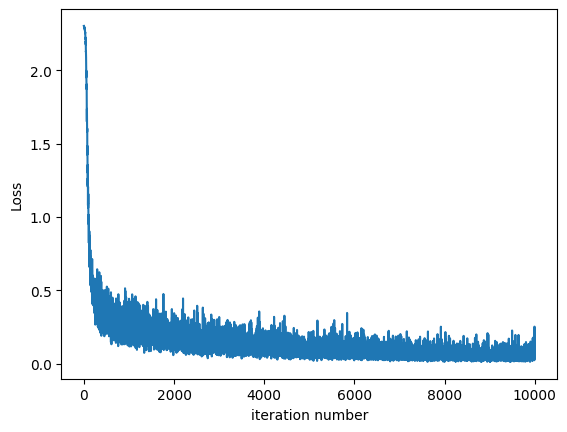

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(iteration_num), train_loss_list)
plt.ylabel("Loss")
plt.xlabel("iteration number")
plt.show()

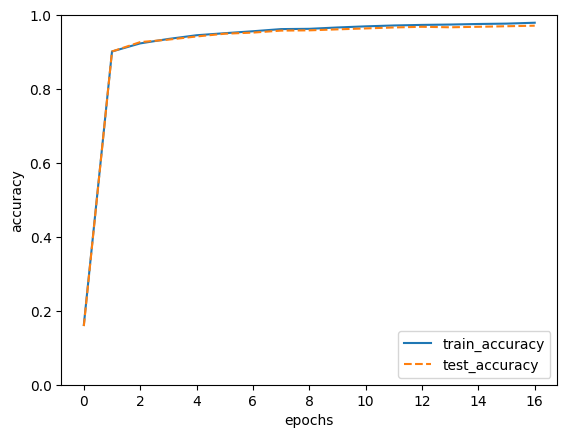

In [15]:
x = np.arange(len(train_accuracy_list))

plt.plot(x, train_accuracy_list, label = "train_accuracy")
plt.plot(x, test_accuracy_list, label = "test_accuracy", linestyle = "--")

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc = "lower right") # 凡例を表示

plt.show()